In [10]:
#### Helper functions
## Prepare features - reduct dimensions for Motion energy
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import check_cv
from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.delayer import Delayer
from voxelwise_tutorials.utils import generate_leave_one_run_out
from himalaya.backend import set_backend
from himalaya.kernel_ridge import MultipleKernelRidgeCV, Kernelizer, ColumnKernelizer
from himalaya.scoring import r2_score_split
def get_euclidean_distance(feature):
    """
        Compute the Euclidean distances within a feature
    """
    distance_matrix = []

    for i in range(len(feature)):
        column = []
        for j in range(len(feature)):
            dist = np.linalg.norm(feature[i]-feature[j])
            column.append(dist)
        distance_matrix.append(column)
    return distance_matrix

def correlate_matrices(matrix1, matrix2):
    """
        Return a correlation matrix and a single correlation coefficient for the two sets.
    """
    ## Extract matrix
    rdm = np.corrcoef(matrix1, matrix2)
    # Get only the part of the matrix where the two features are correlated -- the bottom left quarter
    rdm_trimmed = rdm[len(matrix1):len(rdm),0:len(matrix1)]
    
    ## Extract coefficient
    matrix1_flat = flat_tril_matrix(matrix1)
    matrix2_flat = flat_tril_matrix(matrix2)
    corr_coef = np.corrcoef(matrix1_flat, matrix2_flat)[0][1]
    
    return rdm_trimmed, corr_coef

def flat_tril_matrix(matrix):
    """
        Get the flattened lower triangular of a matrix
    """
    # Put NaNs in the upper triangular
    matrix = np.tril(matrix) # Guarantees an NP array
    matrix[np.triu_indices(n=np.shape(matrix)[0], k=-1)] = np.nan
    # Convert matrix to 1 dimension
    matrix_flat = np.ravel(matrix)
    # Remove NaNs so only flat lower triangular remains
    matrix_flat = matrix_flat[~np.isnan(matrix_flat)]
    return matrix_flat
os.chdir('/Users/mariazimmermann/Dropbox/encoding_model/features_numpy/')
soc = np.load('soc_all.npy')
print(np.shape(soc))
arousal = np.load('tom_all.npy')
print(np.shape(arousal))
valence = np.load('valence2.npy')
print(np.shape(valence))
correlation_matrix = np.corrcoef(arousal[:, 0], soc[:, 1])

# Extract the correlation coefficient
correlation = correlation_matrix[0, 1]
print(correlation)

(1425, 2)
(1425, 2)
(1425, 3)
0.007968706234010758


In [9]:
import numpy as np
from scipy.stats import spearmanr

# Example data (replace with your real ratings)
# Shape should be (1425, 3) — rows = items, columns = raters
rater_data = valence

# Compute Spearman correlation matrix
corr, _ = spearmanr(rater_data, axis=0)

# Extract the upper triangle (excluding diagonal) of the correlation matrix
# to get the pairwise correlations between different raters
triu_indices = np.triu_indices_from(corr, k=1)
pairwise_rhos = corr[triu_indices]

# Average pairwise Spearman rho
average_rho = np.mean(pairwise_rhos)

print(f"Average Spearman correlation (rho) between raters: {average_rho:.3f}")


Average Spearman correlation (rho) between raters: 0.648


In [41]:
os.chdir('/Users/mariazimmermann/Dropbox/encoding_model/features_numpy/')
#ONE DIMENSIONAL FEATURES 
soc = np.load('social_all.npy')
print(np.shape(soc))
tom = np.load('tom_all.npy')
print(np.shape(tom))
valence = np.load("valence_all.npy")

arousal = np.load("arousal_all.npy")

no = np.load("no_all.npy")

#MULTI DIMENSIONAL 
moten_features=np.load('moten_reduced9.npy')
print(np.shape(moten_features))
interaction_distance = get_euclidean_distance(soc)
tom_distance = get_euclidean_distance(tom)
arousal_distance = get_euclidean_distance(arousal)
valence_distance = get_euclidean_distance(valence)
no_distance = get_euclidean_distance(no)


moten_rsm = np.corrcoef(moten_features)
moten_rdm = 1 - moten_rsm

interaction_moten_rdm, interaction_moten_corr = correlate_matrices(interaction_distance, moten_rdm)
tom_moten_rdm, tom_moten_corr = correlate_matrices(tom_distance, moten_rdm)
arousal_moten_rdm, arousal_moten_corr = correlate_matrices(arousal_distance, moten_rdm)
valence_moten_rdm, valence_moten_corr = correlate_matrices(valence_distance, moten_rdm)
no_moten_rdm, no_moten_corr = correlate_matrices(no_distance, moten_rdm)

print(tom_moten_corr)
print(interaction_moten_corr)
print(arousal_moten_corr)
print(valence_moten_corr)
print(no_moten_corr)

(1424,)
(1424,)
(1424, 9)
0.06874271619527461
0.006515795778686573
0.049325350164528076
0.009321132094630886
0.04077832870057057


Data shape: (1424, 5)
[[ 1.          0.11845885 -0.05877801 -0.03388424 -0.03030108]
 [ 0.11845885  1.         -0.00569526  0.08204324  0.06114336]
 [-0.05877801 -0.00569526  1.          0.00516727  0.1163222 ]
 [-0.03388424  0.08204324  0.00516727  1.          0.24052723]
 [-0.03030108  0.06114336  0.1163222   0.24052723  1.        ]]
(5, 5)


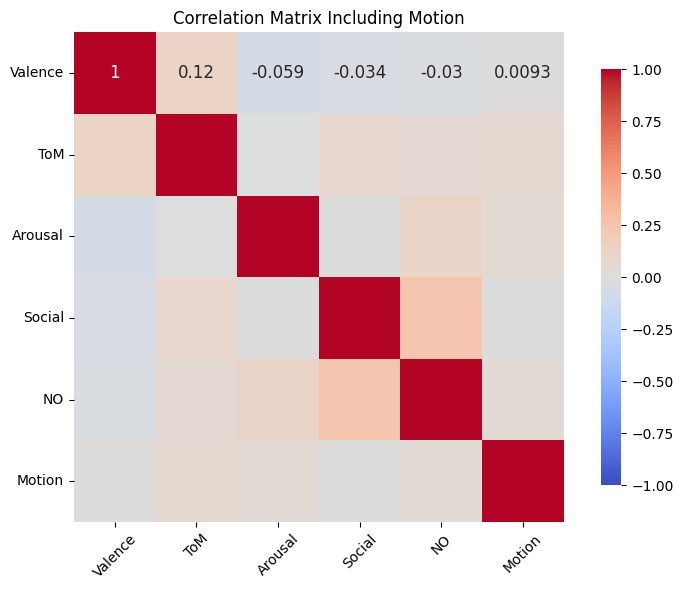

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/mariazimmermann/Dropbox/encoding_model/features_numpy/')
# Load your (1424,) arrays
valence = np.load("valence_all.npy")
tom = np.load("tom_all.npy")
arousal = np.load("arousal_all.npy")
social = np.load("social_all.npy")
no = np.load("no_all.npy")



# Stack as columns => shape = (1424, 5)
data = np.stack([valence, tom, arousal, social, no], axis=1)

# Double-check shape
print("Data shape:", data.shape)  # Should be (1424, 5)

# Compute correlation matrix between columns
corr5 = np.corrcoef(data, rowvar=False)
print(corr5)
print(np.shape(corr5))
np.save('corr_ma.npy', corr5)

# Existing 5x5 correlation matrix
labels = ["Valence", "ToM", "Arousal", "Social", "NO"]

# Your known correlations between each feature and "motion"
motion_corrs = [
    valence_moten_corr,
    tom_moten_corr,
    arousal_moten_corr,
    interaction_moten_corr,
    no_moten_corr
]

# Add the "motion" row and column to the correlation matrix
motion_row = np.array(motion_corrs + [1.0])  # 6 elements
corr6 = np.vstack([corr5, motion_corrs])     # Add as new row (shape: 6, 5)
corr6 = np.column_stack([corr6, motion_row]) # Add as new column (shape: 6, 6)

# Add "Motion" to labels
labels.append("Motion")

# Plot the updated heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr6,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'shrink': 0.85},
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 12}
)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.title("Correlation Matrix Including Motion")
plt.tight_layout()
plt.show()










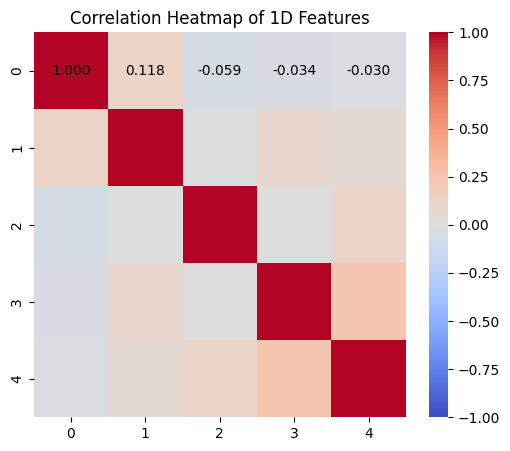

In [38]:

corr6=np.load('corr_ma.npy')
# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr6, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1,annot_kws={"color": "black"})
plt.title("Correlation Heatmap of 1D Features")

plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = ["Valence", "ToM", "Arousal", "Social", "NO"]




Matrix dtype: float64
Matrix values:
 [[ 1.          0.11845885 -0.05877801 -0.03388424 -0.03030108  0.00932113]
 [ 0.11845885  1.         -0.00569526  0.08204324  0.06114336  0.06874272]
 [-0.05877801 -0.00569526  1.          0.00516727  0.1163222   0.04932535]
 [-0.03388424  0.08204324  0.00516727  1.          0.24052723  0.0065158 ]
 [-0.03030108  0.06114336  0.1163222   0.24052723  1.          0.04077833]
 [ 0.00932113  0.06874272  0.04932535  0.0065158   0.04077833  1.        ]]


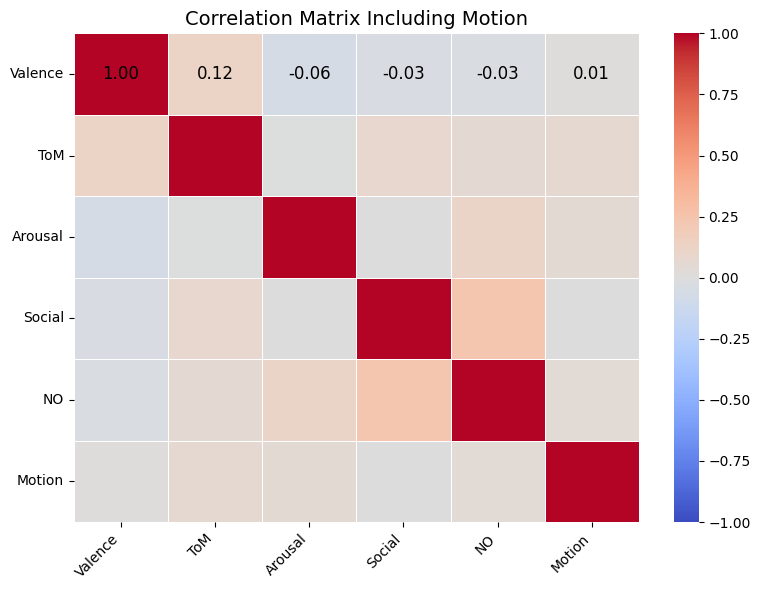

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
corr6 = corr6.astype(float)
plt.figure(figsize=(8, 6))
print("Matrix dtype:", corr6.dtype)
print("Matrix values:\n", corr6)
sns.heatmap(
    corr6,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
   
    linewidths=0.5,
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 12, "color": "black"}  # ensures visibility
)

plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.title("Correlation Matrix Including Motion", fontsize=14)
plt.tight_layout()
plt.show()


Data shape: (1424, 5)
[[ 1.          0.11845885 -0.05877801 -0.03388424 -0.03030108]
 [ 0.11845885  1.         -0.00569526  0.08204324  0.06114336]
 [-0.05877801 -0.00569526  1.          0.00516727  0.1163222 ]
 [-0.03388424  0.08204324  0.00516727  1.          0.24052723]
 [-0.03030108  0.06114336  0.1163222   0.24052723  1.        ]]


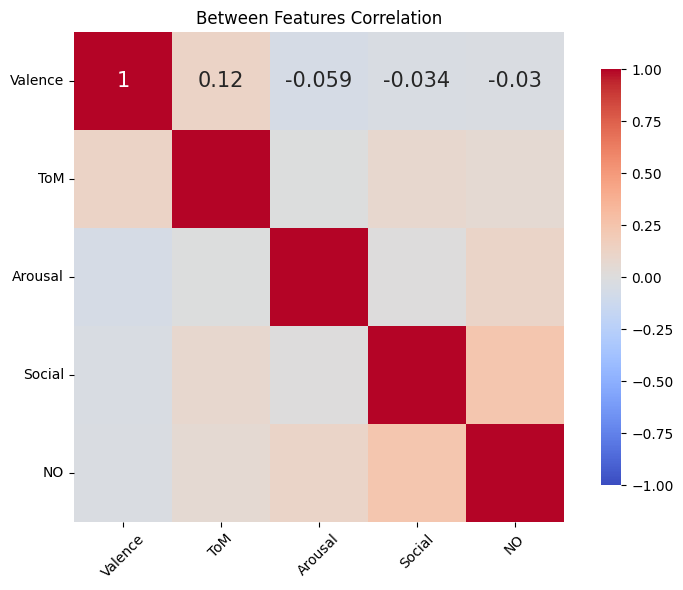

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Users/mariazimmermann/Dropbox/encoding_model/features_numpy/')

# Load your (1424,) arrays
valence = np.load("valence_all.npy")
tom = np.load("tom_all.npy")
arousal = np.load("arousal_all.npy")
social = np.load("social_all.npy")
no = np.load("no_all.npy")

# Stack as columns => shape = (1424, 5)
data = np.stack([valence, tom, arousal, social, no], axis=1)
print("Data shape:", data.shape)

# Compute correlation matrix
corr5 = np.corrcoef(data, rowvar=False)
print(corr5)
np.save('corr_ma.npy', corr5)

# Labels
labels = ["Valence", "ToM", "Arousal", "Social", "NO"]

# Plot full matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr5,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'shrink': 0.85},
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 15}
)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.title("Between Features Correlation")
plt.tight_layout()
plt.show()


HSV.hdf5: (4260,)
NO.hdf5: (1420,)
AROUSAL.hdf5: (2840,)
SOC.hdf5: (2840,)
FACES.hdf5: (1420,)
TOM.hdf5: (2840,)
MOTION.hdf5: (3592600,)


/Users/mariazimmermann/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/mariazimmermann/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


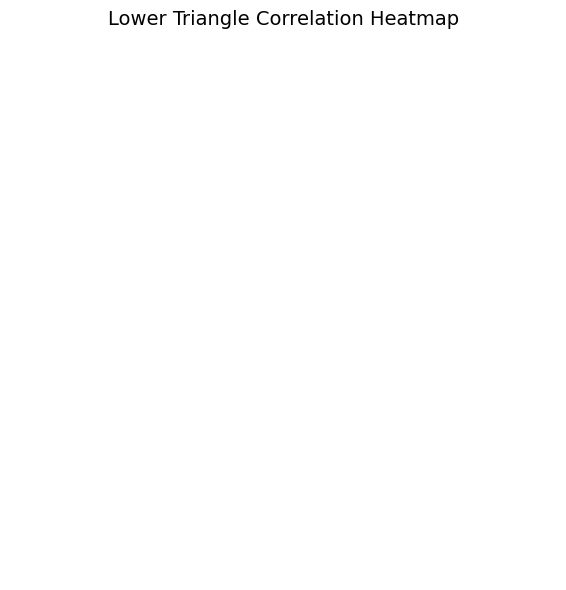

In [54]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/mariazimmermann/dropbox/encoding_model/features')

# --- Plot triangular heatmap ---
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="BuGn",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=False
)
plt.xticks(rotation=45, ha="right")
plt.title("Lower Triangle Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


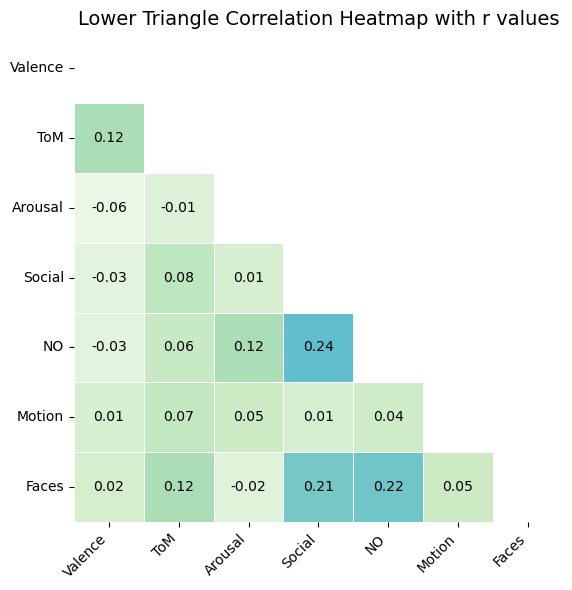

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Labels
labels = ["Valence", "ToM", "Arousal", "Social", "NO", "Motion", "Faces"]

# Manually entered symmetric correlation matrix
data = [
    [1.00, 0.12, -0.06, -0.03, -0.03,  0.01,  0.02],
    [0.12, 1.00, -0.01,  0.08,  0.06,  0.07,  0.12],
    [-0.06,-0.01, 1.00,  0.01,  0.12,  0.05, -0.02],
    [-0.03, 0.08, 0.01,  1.00,  0.24,  0.01,  0.21],
    [-0.03, 0.06, 0.12,  0.24,  1.00,  0.04,  0.22],
    [0.01,  0.07, 0.05,  0.01,  0.04,  1.00,  0.05],
    [0.02,  0.12,-0.02,  0.21,  0.22,  0.05,  1.00]
]

# Create DataFrame
df = pd.DataFrame(data, index=labels, columns=labels)

# Lower triangle mask
mask = np.triu(np.ones_like(df, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt=".2f",
            cmap='GnBu', square=True, linewidths=0.5,
            cbar=False, vmin=-0.1, vmax=0.5,
            annot_kws={"size": 10, "color": "black"})

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Lower Triangle Correlation Heatmap with r values", fontsize=14)
plt.tight_layout()
plt.show()

